# Projet MLOps – Pré-traitement des données

## Objectif
Nettoyer et préparer le jeu de données afin de produire une version exploitable pour la modélisation.


## Bibliothèque

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns


## Importation des données

In [2]:
DATA_PATH = "../data/raw/revenus.csv"

try:
    df = pd.read_csv(DATA_PATH, sep=",")
except:
    df = pd.read_csv(DATA_PATH, sep=",")

df.shape, df.head()


((48842, 15),
    age  workclass  fnlwgt     education  educational-num      marital-status  \
 0   25    Private  226802          11th                7       Never-married   
 1   38    Private   89814       HS-grad                9  Married-civ-spouse   
 2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
 3   44    Private  160323  Some-college               10  Married-civ-spouse   
 4   18          ?  103497  Some-college               10       Never-married   
 
           occupation relationship   race  gender  capital-gain  capital-loss  \
 0  Machine-op-inspct    Own-child  Black    Male             0             0   
 1    Farming-fishing      Husband  White    Male             0             0   
 2    Protective-serv      Husband  White    Male             0             0   
 3  Machine-op-inspct      Husband  Black    Male          7688             0   
 4                  ?    Own-child  White  Female             0             0   
 
    hours-

## Nettoyage variables (valeurs manquantes/aberrantes, recodage et regroupement)


In [16]:
import numpy as np
import pandas as pd

def clean_data(df_input: pd.DataFrame) -> pd.DataFrame:
    df_cleaned = df_input.copy()

    # 1) supprimer fnlwgt + harmoniser les noms de colonnes
    if "fnlwgt" in df_cleaned.columns:
        df_cleaned = df_cleaned.drop(columns=["fnlwgt"])

    # remplace les "-" par "_" (ex: capital-gain -> capital_gain)
    df_cleaned.columns = df_cleaned.columns.str.replace("-", "_", regex=False)

    # 2) remplacer "?" par "Non renseigné" (sur colonnes concernées)
    for c in ["occupation", "workclass", "native_country"]:
        if c in df_cleaned.columns:
            df_cleaned[c] = df_cleaned[c].astype(str).str.replace("?", "Non renseigné", regex=False)

    # 3) âge en classes
    if "age" in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned["age"]):
        bins = [0, 18, 30, 50, 65, float("inf")]
        labels = ["Moins de 18", "Entre 18 et 30 ans", "Entre 31 et 50 ans", "Entre 51 et 65 ans", "Plus de 65 ans"]
        df_cleaned["age"] = pd.cut(df_cleaned["age"], bins=bins, labels=labels, right=False)

    # 4) capital_gain / capital_loss (après renommage)
    if "capital_gain" in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned["capital_gain"]):
        df_cleaned["capital_gain"] = np.where(df_cleaned["capital_gain"] > 0, "Gain de capital", "Pas de gain de capital")

    if "capital_loss" in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned["capital_loss"]):
        df_cleaned["capital_loss"] = np.where(df_cleaned["capital_loss"] > 0, "Perte de capital", "Pas de perte de capital")

    # 5) hours_per_week
    if "hours_per_week" in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned["hours_per_week"]):
        df_cleaned["hours_per_week"] = pd.cut(
            df_cleaned["hours_per_week"],
            bins=[0, 40, 50, float("inf")],
            labels=["under_employed", "normally_employed", "over_employed"],
            right=False
        )

    # 6) native_country (USA / Not USA)
    if "native_country" in df_cleaned.columns:
        df_cleaned["native_country"] = np.where(
            df_cleaned["native_country"] == "United-States", "USA", "Not USA"
        )

    # 7) relationship – regroupement raisonné
    if "relationship" in df_cleaned.columns:
        df_cleaned["relationship"] = df_cleaned["relationship"].replace({
            "Husband": "Married",
            "Wife": "Married",
            "Own-child": "Own-child",
            "Not-in-family": "Others",
            "Other-relative": "Others",
            "Unmarried": "Unmarried"
        })

    # 8) race (White / Black / Other)
    if "race" in df_cleaned.columns:
        df_cleaned["race"] = np.where(
            df_cleaned["race"] == "White", "White",
            np.where(df_cleaned["race"] == "Black", "Black", "Other")
        )

    # 9) occupation mapping
    if "occupation" in df_cleaned.columns:
        occupation_mapping = {
            "Tech-support": "White Collar",
            "Craft-repair": "Blue Collar",
            "Other-service": "Other",
            "Sales": "Sales",
            "Exec-managerial": "White Collar",
            "Prof-specialty": "White Collar",
            "Handlers-cleaners": "Blue Collar",
            "Machine-op-inspct": "Blue Collar",
            "Adm-clerical": "White Collar",
            "Farming-fishing": "Agriculture",
            "Transport-moving": "Blue Collar",
            "Priv-house-serv": "Blue Collar",
            "Protective-serv": "Protective Services",
            "Armed-Forces": "Protective Services",
            "Non renseigné": "Other"
        }
        df_cleaned["occupation"] = df_cleaned["occupation"].replace(occupation_mapping)

    # 10) workclass regroupement
    if "workclass" in df_cleaned.columns:
        df_cleaned["workclass"] = df_cleaned["workclass"].replace({
            "Local-gov": "Gov",
            "State-gov": "Gov",
            "Federal-gov": "Gov",
            "Self-emp-not-inc": "Self_emp",
            "Self-emp-inc": "Self_emp",
            "Without-pay": "Other",
            "Never-worked": "Other",
            "Non renseigné": "Non renseigné"
        })

    # 11) education regroupement
    if "education" in df_cleaned.columns:
        df_cleaned["education"] = df_cleaned["education"].replace({
            "Preschool": "Primary", "1st-4th": "Primary", "5th-6th": "Primary",
            "7th-8th": "Middle_Low", "9th": "Middle_Low", "10th": "Middle_Low",
            "11th": "Middle_Low", "12th": "Middle_Low",
            "HS-grad": "HighSchool_SomeCollege", "Some-college": "HighSchool_SomeCollege",
            "Assoc-voc": "HighSchool_SomeCollege", "Assoc-acdm": "HighSchool_SomeCollege",
            "Bachelors": "Higher", "Masters": "Higher", "Prof-school": "Higher", "Doctorate": "Higher"
        })
    
    # Regroupement de marital_status (modalités courtes et en anglais)
    if "marital_status" in df_cleaned.columns:
        df_cleaned["marital_status"] = df_cleaned["marital_status"].replace({
        "Married-civ-spouse": "Married",
        "Married-AF-spouse": "Married",
        "Never-married": "Never_married",
        "Divorced": "Divorced",
        "Separated": "Separated",
        "Widowed": "Widowed",
        "Married-spouse-absent": "Separated"
        })

        
    #variable gender (2 modalités unique), educational_num (pas d'infos sur les modalités), pas regrouper

    return df_cleaned


# Application
df = clean_data(df)


In [17]:
print(df)
#df.head()
df.dtypes
df["income"].value_counts()

                      age      workclass               education  \
0      Entre 18 et 30 ans        Private              Middle_Low   
1      Entre 31 et 50 ans        Private  HighSchool_SomeCollege   
2      Entre 18 et 30 ans            Gov  HighSchool_SomeCollege   
3      Entre 31 et 50 ans        Private  HighSchool_SomeCollege   
4      Entre 18 et 30 ans  Non renseigné  HighSchool_SomeCollege   
...                   ...            ...                     ...   
48837  Entre 18 et 30 ans        Private  HighSchool_SomeCollege   
48838  Entre 31 et 50 ans        Private  HighSchool_SomeCollege   
48839  Entre 51 et 65 ans        Private  HighSchool_SomeCollege   
48840  Entre 18 et 30 ans        Private  HighSchool_SomeCollege   
48841  Entre 51 et 65 ans       Self_emp  HighSchool_SomeCollege   

       educational_num marital_status           occupation relationship  \
0                    7  Never_married          Blue Collar    Own-child   
1                    9        Mar

income
<=50K    37155
>50K     11687
Name: count, dtype: int64

## Etude des liens (Matrice Vcramer)

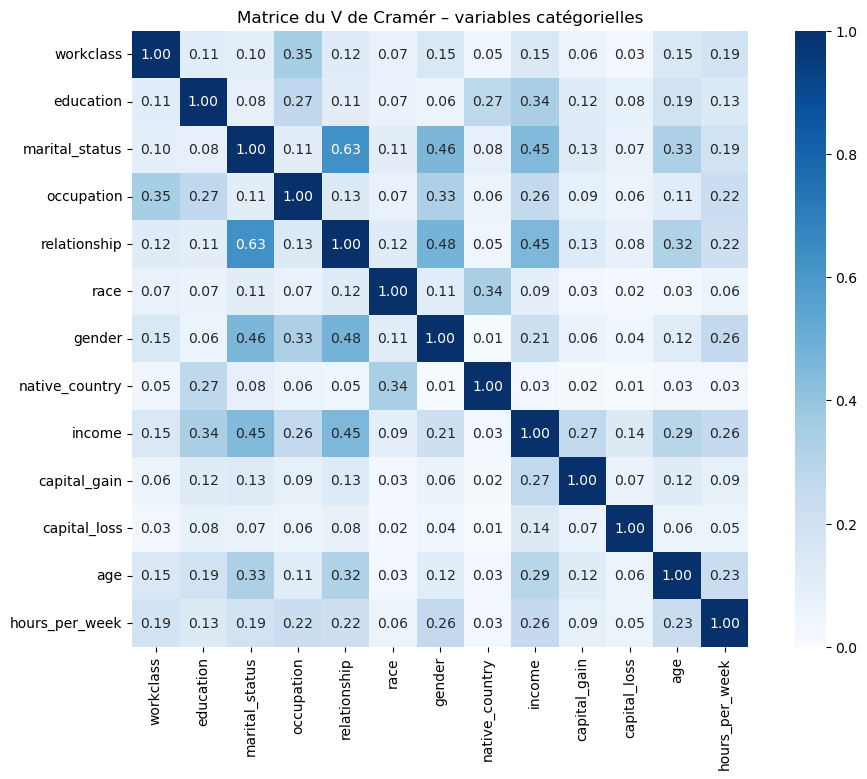

In [19]:
# Sélection des variables catégorielles
vars_categorielles = [
    "workclass",
    "education",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "native_country",
    "income", 
    "capital_gain", 
    "capital_loss", 
    #"educational_num", 
    "age", 
    "hours_per_week"
]

# Création des tables de contingence
contingency_tables = {}
for var1 in vars_categorielles:
    for var2 in vars_categorielles:
        contingency_table = pd.crosstab(df[var1], df[var2])
        contingency_tables[(var1, var2)] = contingency_table

# Calcul du V de Cramer
cramer_v_values = {}
for (var1, var2), contingency_table in contingency_tables.items():
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))
    cramer_v_values[(var1, var2)] = cramers_v

# Matrice du V de Cramer
cramer_df = pd.DataFrame(index=vars_categorielles, columns=vars_categorielles)
for var1 in vars_categorielles:
    for var2 in vars_categorielles:
        cramer_df.loc[var1, var2] = cramer_v_values.get(
            (var1, var2),
            cramer_v_values.get((var2, var1))
        )

cramer_df = cramer_df.astype(float)

# Heatmap BLEUE
plt.figure(figsize=(12, 8))
sns.heatmap(
    cramer_df,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    square=True,
    vmin=0,
    vmax=1
)

plt.title("Matrice du V de Cramér – variables catégorielles")
plt.show()

Commentaire : L’analyse de la matrice du V de Cramér met en évidence plusieurs variables présentant une association notable avec la variable cible income, traduisant des liens structurels entre le niveau de revenu et certaines caractéristiques socio-démographiques et professionnelles.
- Fortement lié : Les variables marital_status et relationship apparaissent comme les plus fortement liées au revenu (V ≈ 0.45). 
- Modérément lié : La variable education présente également une association significative avec income (V ≈ 0.34), traduisant le rôle central du capital humain dans la structuration des inégalités de revenus. L’âge (V ≈ 0.29) suggère un effet du cycle de vie professionnel, où l’accumulation d’expérience et l’ancienneté peuvent influencer le niveau de rémunération. Les variables hours_per_week (V ≈ 0.26) et occupation (V ≈ 0.26) indiquent que l’intensité du travail ainsi que le type d’activité professionnelle constituent également des déterminants importants du revenu. Enfin, la variable capital_gain (V ≈ 0.27) révèle l’impact des revenus du capital dans la distinction des niveaux de revenus, en particulier pour les individus appartenant aux catégories de revenus élevés.
- Faiblement lié : Les variables native_country (0.03), race (0,09), gender(0,21), workclass(0.15) et capital_loss (0.14) présentent des valeurs de V de Cramér faibles, traduisant une association limitée avec la variable income lorsqu’elles sont considérées isolément.

L’étude des dépendances entre variables explicatives met en évidence certaines redondances susceptibles d’influencer la construction du modèle.
- La relation la plus marquée concerne les variables marital_status et relationship (V ≈ 0.63). Cette forte association indique que ces deux variables véhiculent une information très proche sur la situation familiale des individus. 
- De fortes associations sont également observées entre relationship et gender (V ≈ 0.48), ainsi qu’entre marital_status et gender (V ≈ 0.46), traduisant des structures sociales genrées dans les rôles familiaux. 
- Des liens modérés existent entre education et occupation (0.27), ainsi qu’entre occupation et workclass(0.35), ce qui est cohérent avec la structuration du marché du travail, sans pour autant constituer des redondances strictes.
Ces dépendances doivent être prises en compte lors de la sélection finale des variables afin de limiter les effets de colinéarité.

À l’issue de cette analyse, les variables *education, age, hours_per_week, occupation, capital_gain et une seule variable décrivant la situation familiale : marital_status* apparaissent comme les plus pertinentes pour la suite de l’analyse bivariée et la phase de modélisation.
Les variables présentant à la fois une faible association avec la variable cible et une redondance limitée pourront être écartées ou intégrées de manière secondaire selon les performances observées lors de la modélisation.

## Statistiques bivariées

In [21]:
def bivariate_analysis(df, var, target="income"):
    # Tableau croisé en effectifs
    ct_counts = pd.crosstab(df[var], df[target])

    # Tableau croisé en pourcentage ligne
    ct_percent = pd.crosstab(
        df[var],
        df[target],
        normalize="index"
    ) * 100

    # Affichage
    print("Tableau croisé – effectifs")
    display(ct_counts)

    print("Tableau croisé – pourcentages (%)")
    display(ct_percent.round(2))

    # Graphique en % (barres empilées)
    ct_percent.plot(
        kind="bar",
        stacked=True,
        figsize=(8, 5)
    )

    plt.title(f"{var} et Revenu (%)")
    plt.ylabel("Pourcentage (%)")
    plt.xlabel(var)
    plt.legend(title=target)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


##### Education et Revenu

Tableau croisé – effectifs


income,<=50K,>50K
education,,
HighSchool_SomeCollege,24823,5501
Higher,6290,5820
Middle_Low,5239,330
Primary,803,36


Tableau croisé – pourcentages (%)


income,<=50K,>50K
education,,
HighSchool_SomeCollege,81.86,18.14
Higher,51.94,48.06
Middle_Low,94.07,5.93
Primary,95.71,4.29


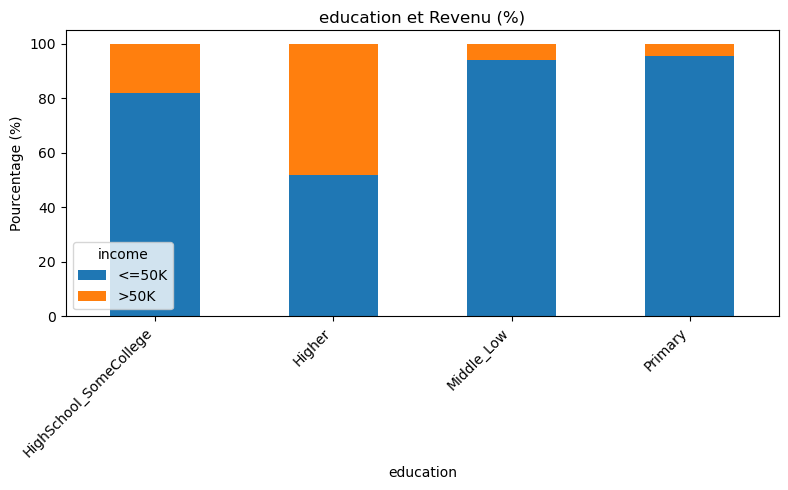

In [22]:
bivariate_analysis(df, "education")


##### Age et Revenu

Tableau croisé – effectifs


income,<=50K,>50K
age,,
Moins de 18,595,0
Entre 18 et 30 ans,13174,746
Entre 31 et 50 ans,16206,7447
Entre 51 et 65 ans,5520,3067
Plus de 65 ans,1660,427


Tableau croisé – pourcentages (%)


income,<=50K,>50K
age,,
Moins de 18,100.00,0.00
Entre 18 et 30 ans,94.64,5.36
Entre 31 et 50 ans,68.52,31.48
Entre 51 et 65 ans,64.28,35.72
Plus de 65 ans,79.54,20.46


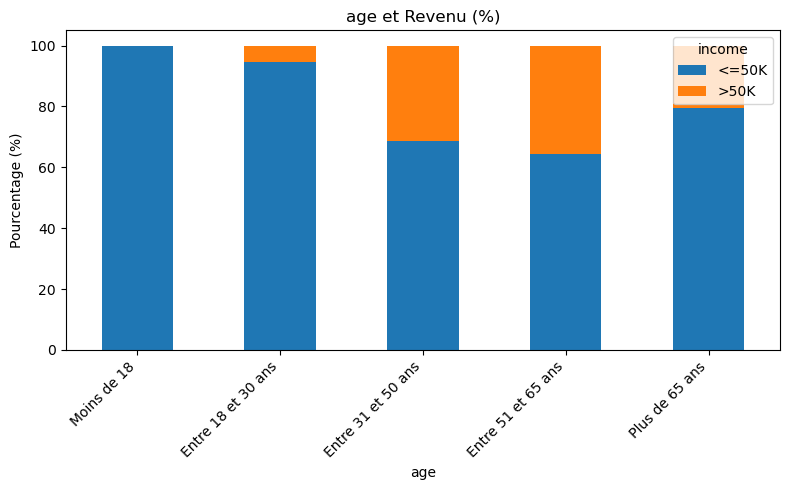

In [24]:
bivariate_analysis(df, "age")

##### Hours_peer-week et Revenu

Tableau croisé – effectifs


income,<=50K,>50K
hours_per_week,,
under_employed,10592,1095
normally_employed,21006,6468
over_employed,5557,4124


Tableau croisé – pourcentages (%)


income,<=50K,>50K
hours_per_week,,
under_employed,90.63,9.37
normally_employed,76.46,23.54
over_employed,57.40,42.60


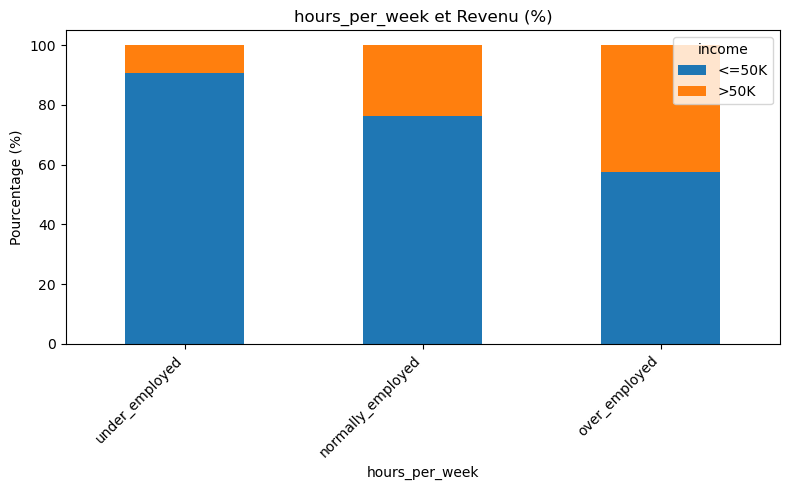

In [25]:
bivariate_analysis(df, "hours_per_week")


##### Occupation et Revenu

Tableau croisé – effectifs


income,<=50K,>50K
occupation,,
Agriculture,1317,173
Blue Collar,11426,2377
Other,7263,469
Protective Services,685,313
Sales,4029,1475
White Collar,12435,6880


Tableau croisé – pourcentages (%)


income,<=50K,>50K
occupation,,
Agriculture,88.39,11.61
Blue Collar,82.78,17.22
Other,93.93,6.07
Protective Services,68.64,31.36
Sales,73.20,26.80
White Collar,64.38,35.62


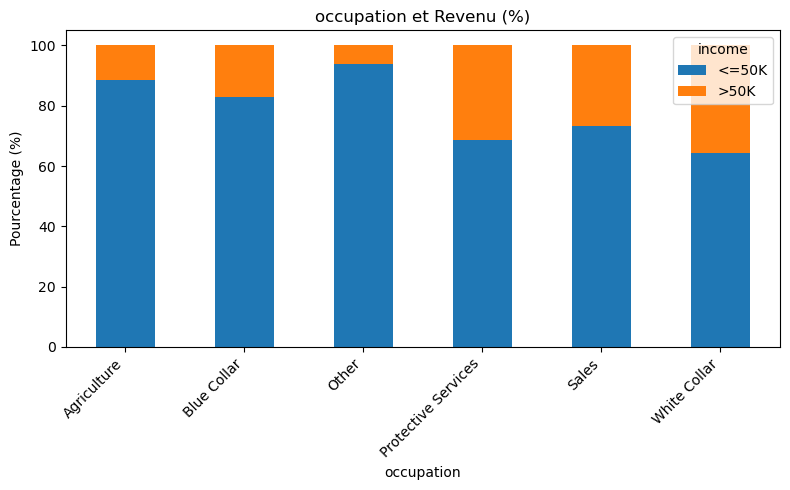

In [26]:
bivariate_analysis(df, "occupation")


##### Capital_gain et Revenu

Tableau croisé – effectifs


income,<=50K,>50K
capital_gain,,
Gain de capital,1544,2491
Pas de gain de capital,35611,9196


Tableau croisé – pourcentages (%)


income,<=50K,>50K
capital_gain,,
Gain de capital,38.27,61.73
Pas de gain de capital,79.48,20.52


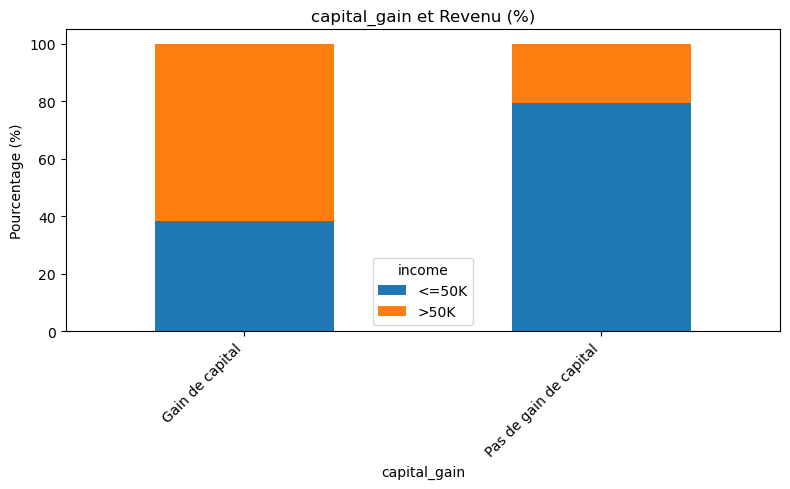

In [27]:
bivariate_analysis(df, "capital_gain")


##### Marital_status et Revenu

Tableau croisé – effectifs


income,<=50K,>50K
marital_status,,
Divorced,5962,671
Married,12418,9998
Never_married,15384,733
Separated,2001,157
Widowed,1390,128


Tableau croisé – pourcentages (%)


income,<=50K,>50K
marital_status,,
Divorced,89.88,10.12
Married,55.40,44.60
Never_married,95.45,4.55
Separated,92.72,7.28
Widowed,91.57,8.43


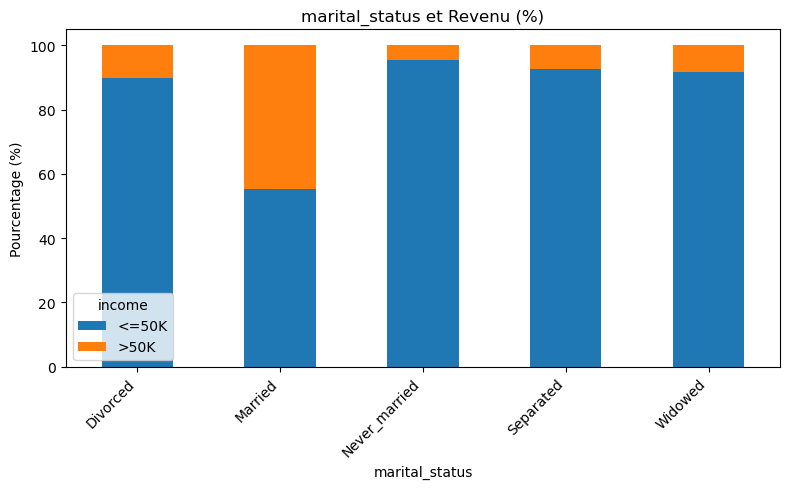

In [28]:
bivariate_analysis(df, "marital_status")


Commentaire : Ces analyses bivariées confirment les résultats observés lors de l’étude de la matrice de dépendance. Les variables présentant des contrastes marqués dans la répartition du revenu seront retenues pour la phase de modélisation.

## Exportation

#### Données pré-traiter

In [30]:
# Export du dataset prétraité complet
df.to_csv("../data/processed/data_cleaned.csv", index=False)

#### Données modélisation

In [31]:
features = [
    "education",
    "age",
    "hours_per_week",
    "occupation",
    "capital_gain",
    "marital_status"
]

target = "income"


In [32]:
df_model = df[features + [target]].copy()


In [33]:
df_model.to_csv("../data/modelisation/data_modeling.csv", index=False)
